In [50]:
%matplotlib inline


# 使用随机森林进行人脸识别
原始数据库位置<br>
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

我们只挑选其中的5个人来进行实验。<br><br>
Ariel_Sharon: 阿里埃勒·沙龙（1928年2月26日－2014年1月11日，以色列前总理，而且是经验丰富的将军，沙龙也是利库德集团创建人之一，亦是前任主席。）<br>
Colin Powell: 科林·鲍威尔 第65任美国国务卿，美国历史上首位任职美国国务卿的非裔美国人<br>
Donald_Rumsfeld: 唐纳德·亨利·拉姆斯菲尔德（Donald Henry Rumsfeld，1932年7月9日－），出生于美国伊利诺州，曾两度出任美国国防部长。他一直被外界认为是小布什内阁中的著名鹰派代表人物之一。<br>
George_W_Bush: 乔治·沃克·布什（George Walker Bush），政治家，1946年7月6日出生于美国康涅狄格州。于1995年-2000年间担任第46任的得克萨斯州州长。于2001年-2009年担任美国第43任（第54届-第55届）总统，任内遭遇了2001年的9·11事件，他因此发动了一连串反恐战争。<br>
Gerhard_Schroeder： 格哈特·弗里茨·库尔特·施罗德（关于这个音频文件 Gerhard Fritz Kurt Schröder 帮助·信息，1944年4月7日－），生于北莱茵-威斯特法伦的莫森贝格，德国政治家，曾任德国总理。<br>

## 1. 引入需要的包

In [1]:
from time import time
import logging
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from PIL import Image

## 1. 查看数据 

In [2]:
img = Image.open('./data/face_img/Ariel_Sharon/Ariel_Sharon_0001.jpg')
print(img.mode)
print(img.size)

RGB
(250, 250)


## 2. 加载数据

In [3]:
# 定义一个字典，存放人民与类的id
CLASS_MAP = {'Ariel_Sharon': 0,
             'Colin_Powell': 1,
             'Donald_Rumsfeld': 2,  
             'George_W_Bush': 3,
             'Gerhard_Schroeder': 4}
# 将字典的key与value反转
INDEX_CLASS = dict((value, key) for key,value in CLASS_MAP.items())

In [4]:
img_list = []
label_list = []
def load_face_data(img_path):
    for face in os.listdir(img_path):
        if face == '.DS_Store':
            continue
        for face_img in os.listdir(img_path + os.sep + face):
            # 用PIL打开图片存保存为numpy的数组
            face_img_array = np.asarray(Image.open(img_path + os.sep + face + os.sep + face_img))
            # flatten() 转换为1行数据
            img_list.append(face_img_array.flatten())
            label_list.append(CLASS_MAP[face])
            
    return np.array(img_list), np.array(label_list)
face_imgs, face_label = load_face_data('./data/face_img')
print(face_imgs.shape, face_label.shape)
print(np.unique(face_label))

(1073, 187500) (1073,)
[0 1 2 3 4]


In [5]:
# 获得特征数目
n_features = face_imgs.shape[1]
#y = label_list
target_names = np.unique(face_label)
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(
    face_imgs, face_label, test_size=0.25, random_state=42)
print(X_train.shape)

Total dataset size:
n_features: 187500
n_classes: 5
(804, 187500)


## 3. 训练随机森林

In [6]:
print("Fitting the classifier to the training set")
t0 = time()
model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='log2', max_depth=6, oob_score=True)
clf = model.fit(X_train, y_train)
print('fit done')
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
fit done
done in 15.128s


## 4. 预测与评估

In [11]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.169s


### 打印评估信息

In [12]:
print(classification_report(y_test, y_pred))
range(n_classes)
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

              precision    recall  f1-score   support

           0       0.89      0.47      0.62        17
           1       1.00      0.30      0.46        70
           2       0.00      0.00      0.00        22
           3       0.57      1.00      0.72       127
           4       0.93      0.42      0.58        33

   micro avg       0.63      0.63      0.63       269
   macro avg       0.68      0.44      0.48       269
weighted avg       0.70      0.63      0.57       269

[[  8   0   0   8   1]
 [  1  21   0  48   0]
 [  0   0   0  22   0]
 [  0   0   0 127   0]
 [  0   0   0  19  14]]


/Users/cn40883/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


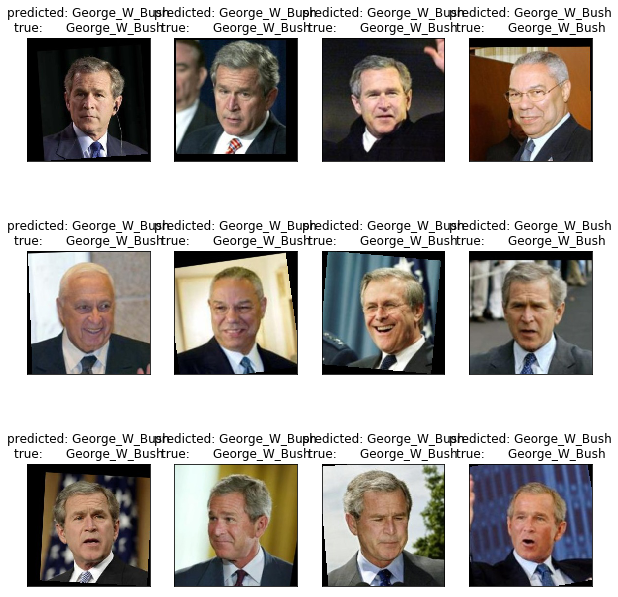

In [14]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        # 从numpy的数组转换为250,250,3的图像
        im = Image.fromarray(images[i].reshape(250, 250, 3))
        plt.imshow(im, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test):
    pred_name = INDEX_CLASS[y_pred[0]]
    true_name = INDEX_CLASS[y_test[0]]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test) for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles)

plt.show()